<a href="https://colab.research.google.com/github/ozakiryota/kaggle/blob/main/titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Downlad and check datasets

Activate Kaggle API

In [4]:
from google.colab import files
import os

jason_path = '/root/.kaggle/kaggle.json'

if not os.path.exists(jason_path):
    uploaded = files.upload()

    for fn in uploaded.keys():
        print('User uploaded file "{name}" with length {length} bytes'.format(
            name=fn, length=len(uploaded[fn])))

    # Then move kaggle.json into the folder where the API expects to find it.
    !mkdir -p /root/.kaggle/ && mv kaggle.json /root/.kaggle/ && chmod 600 /root/.kaggle/kaggle.json

else:
    print(jason_path, "is already exists.")

/root/.kaggle/kaggle.json is already exists.


Download the datasets

In [5]:
!pip install kaggle
!kaggle competitions download -c titanic

  0% 0.00/3.18k [00:00<?, ?B/s]
100% 3.18k/3.18k [00:00<00:00, 2.31MB/s]
  0% 0.00/59.8k [00:00<?, ?B/s]
100% 59.8k/59.8k [00:00<00:00, 54.0MB/s]
  0% 0.00/28.0k [00:00<?, ?B/s]
100% 28.0k/28.0k [00:00<00:00, 49.6MB/s]


Check the datasets

In [6]:
import pandas as pd

df = pd.read_csv('/content/train.csv')
# df = pd.read_csv('/content/test.csv')
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Fuctions and class

In [7]:
import pandas as pd

def makeDataList(csv_path):
    datalist = pd.read_csv(csv_path)
    datalist = datalist.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)
    datalist = datalist.fillna(-1)
    datalist['Sex'] = datalist['Sex'].replace('male', 0)
    datalist['Sex'] = datalist['Sex'].replace('female', 1)
    datalist['Embarked'] = datalist['Embarked'].replace('C', 0)
    datalist['Embarked'] = datalist['Embarked'].replace('Q', 1)
    datalist['Embarked'] = datalist['Embarked'].replace('S', 2)

    return datalist

In [8]:
## TEST
datalist = makeDataList('/content/train.csv')
print('datalist.values[0] =', datalist.values[0])

datalist.values[0] = [ 0.    3.    0.   22.    1.    0.    7.25  2.  ]


In [9]:
## TEST
from sklearn.model_selection import train_test_split

train_datalist, val_datalist = train_test_split(datalist, test_size=0.1, random_state=777, shuffle=True)
print(train_datalist)
print(val_datalist)

     Survived  Pclass  Sex   Age  SibSp  Parch     Fare  Embarked
111         0       3    1  14.5      1      0  14.4542         0
684         0       2    0  60.0      1      1  39.0000         2
513         1       1    1  54.0      1      0  59.4000         0
563         0       3    0  -1.0      0      0   8.0500         2
280         0       3    0  65.0      0      0   7.7500         1
..        ...     ...  ...   ...    ...    ...      ...       ...
71          0       3    1  16.0      5      2  46.9000         2
599         1       1    0  49.0      1      0  56.9292         0
571         1       1    1  53.0      2      0  51.4792         2
815         0       1    0  -1.0      0      0   0.0000         2
103         0       3    0  33.0      0      0   8.6542         2

[801 rows x 8 columns]
     Survived  Pclass  Sex   Age  SibSp  Parch     Fare  Embarked
119         0       3    1   2.0      4      2  31.2750         2
429         1       3    0  32.0      0      0   8.0

In [10]:
import numpy as np

import torch.utils.data as data

class Dataset(data.Dataset):
    def __init__(self, datalist):
        self.datalist = datalist

    def __len__(self):
        return len(self.datalist.values)
    
    def __getitem__(self, index):
        inputs = self.datalist.values[index, 1:].astype(np.float32)
        labels = self.datalist.values[index, 0].astype(np.long)
        return inputs, labels

In [11]:
## TEST
dataset = Dataset(datalist)
print(dataset.__len__())
print(dataset.__getitem__(index=0)[0])
print(dataset.__getitem__(index=0)[1])

891
[ 3.    0.   22.    1.    0.    7.25  2.  ]
0


In [12]:
## TEST
import torch

batch_size = 10
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)
batch_itr = iter(dataloader)
inputs, labels = next(batch_itr)

print("inputs = ", inputs)
print("inputs.size() = ", inputs.size())
print("labels = ", labels)
print("labels.size() = ", labels.size())

inputs =  tensor([[  3.0000,   0.0000,  24.0000,   0.0000,   0.0000,   7.4958,   2.0000],
        [  3.0000,   0.0000,  28.0000,   0.0000,   0.0000,   7.8542,   2.0000],
        [  3.0000,   0.0000,  -1.0000,   0.0000,   0.0000,   7.0500,   2.0000],
        [  2.0000,   1.0000,  24.0000,   2.0000,   3.0000,  18.7500,   2.0000],
        [  2.0000,   0.0000,  31.0000,   1.0000,   1.0000,  26.2500,   2.0000],
        [  3.0000,   0.0000,  18.0000,   1.0000,   0.0000,   6.4958,   2.0000],
        [  3.0000,   0.0000,  16.0000,   0.0000,   0.0000,   7.7750,   2.0000],
        [  3.0000,   0.0000,  19.0000,   0.0000,   0.0000,   7.8958,   2.0000],
        [  3.0000,   0.0000,  16.0000,   1.0000,   1.0000,  20.2500,   2.0000],
        [  1.0000,   1.0000,  50.0000,   0.0000,   1.0000, 247.5208,   0.0000]])
inputs.size() =  torch.Size([10, 7])
labels =  tensor([0, 0, 0, 1, 0, 0, 0, 0, 0, 1])
labels.size() =  torch.Size([10])


In [13]:
from torch import nn

class Network(nn.Module):
    def __init__(self, dim_inputs, dim_mid, dim_outputs, dropout_rate=0.1):
        super().__init__()

        self.fc = nn.Sequential(
            nn.Linear(dim_inputs, dim_mid),
            nn.ReLU(),
            # nn.Dropout(p=dropout_rate),
            nn.Linear(dim_mid, dim_mid),
            nn.ReLU(),
            # nn.Dropout(p=dropout_rate),
            nn.Linear(dim_mid, dim_mid),
            nn.ReLU(),
            # nn.Dropout(p=dropout_rate),
            nn.Linear(dim_mid, dim_outputs)
        )

    def forward(self, x):
        x = self.fc(x)
        return x

In [14]:
## TEST
net = Network(len(dataset.__getitem__(index=0)[0]), 64, 2)
outputs = net(inputs)
print("outputs = ", outputs)

outputs =  tensor([[-2.3112e-02, -8.4273e-01],
        [-1.2263e-02, -9.5798e-01],
        [-4.8138e-02, -3.3459e-01],
        [-3.9138e-03, -1.1304e+00],
        [-1.0374e-02, -1.5822e+00],
        [-2.2904e-02, -6.3791e-01],
        [-2.6696e-02, -6.6004e-01],
        [-2.6137e-02, -7.2296e-01],
        [-6.9155e-02, -1.1034e+00],
        [-1.0698e+00, -1.2410e+01]], grad_fn=<AddmmBackward0>)


self.device =  cpu
Network(
  (fc): Sequential(
    (0): Linear(in_features=7, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=2, bias=True)
  )
)
----------
Epoch 1/100
train Loss: 0.7068
val Loss: 0.6628
----------
Epoch 11/100
train Loss: 0.5404
val Loss: 0.6398
----------
Epoch 21/100
train Loss: 0.4907
val Loss: 0.5747
----------
Epoch 31/100
train Loss: 0.4350
val Loss: 0.5185
----------
Epoch 41/100
train Loss: 0.4221
val Loss: 0.5146
----------
Epoch 51/100
train Loss: 0.4135
val Loss: 0.5011
----------
Epoch 61/100
train Loss: 0.4113
val Loss: 0.5067
----------
Epoch 71/100
train Loss: 0.4293
val Loss: 0.5439
----------
Epoch 81/100
train Loss: 0.3976
val Loss: 0.4997
----------
Epoch 91/100
train Loss: 0.3849
val Loss: 0.4965
training time:  0.0  [min]  15.650146961212158  [sec]


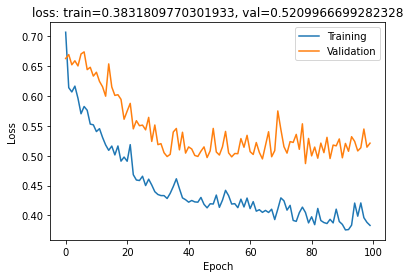

In [19]:
import time
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torch.optim as optim

class Trainer:
    def __init__(self, csv_path, num_epochs, batch_size, lr, save_weights_path):
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        print("self.device = ", self.device)
        
        datalist = makeDataList(csv_path)
        train_datalist, val_datalist = train_test_split(datalist, test_size=0.1, random_state=777, shuffle=True)
        train_dataset = Dataset(train_datalist)
        val_dataset = Dataset(val_datalist)
        train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
        val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=False)
        
        self.num_epochs = num_epochs
        self.dataloaders_dict = {'train': train_dataloader, 'val': val_dataloader}
        self.net = Network(len(train_dataset.__getitem__(index=0)[0]), 64, 2)
        self.net.to(self.device)
        print(net)
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.net.parameters(), lr=lr)

    def train(self):
        ## time
        start_clock = time.time()
        ## record
        record_train_loss = []
        record_val_loss = []
        record_loss_dict = {'train': [], 'val': []}
        ## loop
        for epoch in range(self.num_epochs):
            if not epoch % (num_epochs // 10):
                print('----------')
                print('Epoch {}/{}'.format(epoch+1, self.num_epochs))
            ## phase
            for phase in ["train", "val"]:
                ## setting
                if phase == "train":
                    self.net.train()
                else:
                    self.net.eval()
                ## record
                loss_epoch = 0.0
                for inputs, labels in self.dataloaders_dict[phase]:
                    inputs = inputs.to(self.device)
                    labels = labels.to(self.device)
                    ## reset gradient
                    self.optimizer.zero_grad()
                    ## switch computing gradient
                    with torch.set_grad_enabled(phase == "train"):
                        ## forward
                        outputs = self.net(inputs)
                        loss = self.criterion(outputs, labels)
                        ## backward
                        if phase == "train":
                            loss.backward()
                            self.optimizer.step()
                    ## add loss
                    loss_epoch += loss.item() * inputs.size(0)
                ## average loss
                loss_epoch = loss_epoch / len(self.dataloaders_dict[phase].dataset)
                record_loss_dict[phase].append(loss_epoch)
                if not epoch % (num_epochs // 10):
                    print("{} Loss: {:.4f}".format(phase, loss_epoch))
        ## save
        torch.save(self.net.state_dict(), save_weights_path)
        ## training time
        mins = (time.time() - start_clock) // 60
        secs = (time.time() - start_clock) % 60
        print ('training time: ', mins, ' [min] ', secs, ' [sec]')
        ## graph
        self.showGraph(record_loss_dict)

    def showGraph(self, record_loss_dict):
        graph = plt.figure()
        plt.plot(range(len(record_loss_dict['train'])), record_loss_dict['train'], label="Training")
        plt.plot(range(len(record_loss_dict['val'])), record_loss_dict['val'], label="Validation")
        plt.legend()
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("loss: train=" + str(record_loss_dict['train'][-1]) + ", val=" + str(record_loss_dict['val'][-1]))
        plt.show()


csv_path = '/content/train.csv'
num_epochs = 100
batch_size = 50
lr = 0.001
save_weights_path = '/content/weights.pth'
trainer = Trainer(csv_path, num_epochs, batch_size, lr, save_weights_path)
trainer.train()